In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.projections import register_projection

In [3]:
class IPole(plt.PolarAxes):
    
    name = 'invpole'
    
    def __init__(self, *args, **kwds):
        super(IPole, self).__init__(*args, **kwds)
    
    def scatter(self, vec_, **kwds):
        """
        Plots an inverse pole figure of the given crystallographic directions.
        """
        vec = np.asarray(vec_)
        # ensure vec is 2D
        if len(vec.shape) == 1:
            vec = np.array([vec])
        # confirm that vec has the right dimensions
        assert vec.shape[-1] == 3, \
            'Inverse pole figure requires 1 or more length 3 vectors.'
        # normalize vec
        norm = np.linalg.norm(vec, axis=0)
        norm[norm == 0] = 1
        vec = np.apply_along_axis(lambda x: x/norm, -1, vec)
        # Friedel's law requires antipodal symmetry
        coeff = (2*(vec[:, 2] >= 0) - 1)
        vec = np.apply_along_axis(lambda x : x*coeff, 0, vec)
        # project back to the equatorial plane
        # phi (polar angle of vec). Note: vec = (x, y, z) is normalized
        # opposite leg of phi = $\sqrt{1 - z^2}$
        # adjacent leg of phi = z
        # height from pole = 1 + z
        # similar triangles: $\frac{np.sqrt{1 - z^2}}{1 + z} = r/1$
        #   $r^2 = \frac{1 - z}{1 + z}$
        #   $r = \sqrt{(1 - z)/(1 + z)}$
        z = vec[:, 2]
        radius = np.sqrt((1 - z)/(1 + z))
        # angular location on equatorial plane
        theta = np.array([np.arctan2(y, x) for x,y in vec[:,:2]])
        # plot this position on a polar plot
        pobj = super(IPole, self).scatter(theta, radius, **kwds)
        # remove ticks
        self.set_xticks([])
        self.set_rticks([])
        # finished.
        return pobj

# register the new projection
register_projection(IPole)

## Read Grains.csv

In [4]:
grains = np.genfromtxt('Grains.csv', skip_header=8, names=True, dtype=None)

In [5]:
xyz = [np.matrix(x).T for x in
       grains[np.array(['X', 'Y', 'Z'])].view(np.float64).reshape((-1, 3))]
# MIDAS coordinate system:
#   x: beam direction
#   y: outboard
#   z: up'
# Mc actively transforms a crystal direction to a MIDAS direction, i.e.
# Mc*c = m
# TODO: This is actually a list of matrices, not a single matrix. Recast as such.
Mc = grains[np.array([
            'O11', 'O12', 'O13',
            'O21', 'O22', 'O23',
            'O31', 'O32', 'O33'])].view(np.float64).reshape((-1, 3, 3))
# Sample transform(s)
# Garrison's sample is oriented with the loading axes (X and Y) at 45° to the MIDAS axes,
# therefore, first rotate the MIDAS coordinates about the MIDAS Y axis to the loading
# coordinates, Lm. A crystallographic direction in loading coordinates is
# Lm*Mc*c = Lm*m = l
q = np.radians(45.)
c, s = np.cos(q), np.sin(q)
Lm = np.matrix([
        [ c, 0, s],
        [ 0, 1, 0],
        [-s, 0, c]])
# Sl transforms the loading coordinates to the sample coordinates (RD, TD, ND), so
# a crystallographic direction in sample coordinates is Sl*Lm*Mc*c = Sl*Lm*m = Sl*l = s
Sl = np.matrix([
        [1, 0,  0],
        [0, 0, -1],
        [0, 1,  0]])
# The final transformation from crystal to sample coordinates is Sc = Sl*Lm*Mc, such that
# Sc*c = s
Sc = [Sl*Lm*m for m in Mc]
# For an inverse pole figure, want to know along which sample direction each crystallographic
# direction lies, e.g. an ND pole figure:
#   c = Cs*[0, 0, 1]^T = Sc^(-1)*[0, 0, 1]^T = Sc^T*[0, 0, 1]^T
Cs = np.transpose(Sc, (0, 2, 1))

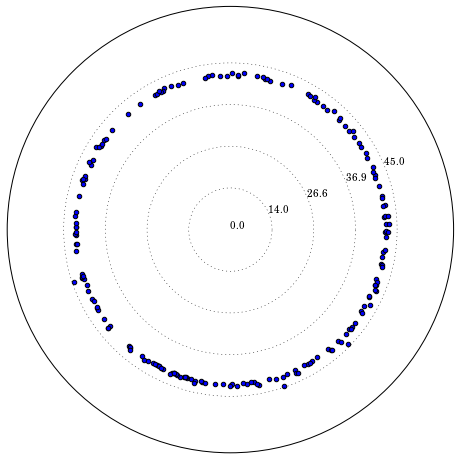

In [16]:
plt.ion()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='invpole')
pc = ax.scatter(Cs[:, :, 2])
_ = ax.set_rticks(np.linspace(0, 1, num=5))
_ = ax.set_yticklabels(map(lambda s: '{:.1f}'.format(s),
                           [np.degrees(np.arctan(x)) for x in np.linspace(0, 1, num=5)]))
plt.show()